<a href="https://colab.research.google.com/github/Sulaiman29/IntelliBrief/blob/main/BDA_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **IntelliBrief News Summarisation System**

**Installing the required dependencies:**

In [2]:
pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 3.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.13.6-py3-none-any.whl.metadata (9.5 kB)
Using cached pybind11-2.13.6-py3-none-any.whl (243 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp311-cp311-linux_x86_64.whl size=4313500 sha256=ba85da62c7097fff6f8502c4545200ff71ca3082ca2ad77a491333869105ffc1
  Stored in directory: /root/.cache/pip/wheels/65/4f/35/5057db0249224e9ab55a513fa6b79451473ceb7713017823c3
Successfully built fasttext


In [3]:
pip install rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=65c9126265e18c2e7f96f85672ccf08f954a26ebdf9a8213037f225775e54f83
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge-score


**Importing important Libraries:**

In [49]:
import fasttext
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer
nltk.download('punkt')
nltk.download('stopwords')
from scipy import spatial
from statistics import mean
from math import ceil
from rouge_score import rouge_scorer
import os

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Mounting the Google drive, to keep our trained models (Easy to use)**

In [6]:
from google.colab import drive

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
%cd /content/drive/MyDrive/

/content/drive/MyDrive


**After training and testing using our saved models to work in a clusterd form**

In [9]:
!ls "/content/drive/MyDrive/models"

model_cbow.bin	model_skipgram.bin


In [10]:
model_skipgram = fasttext.load_model("models/model_skipgram.bin")
model_cbow = fasttext.load_model("models/model_cbow.bin")

**Initiating the task:**

In [11]:
from IPython.display import Image

# Provide the path to your PNG file
image_path = '/content/473172_1_En_16_Fig1_HTML.png'

# Display the image
#Image(filename=image_path)


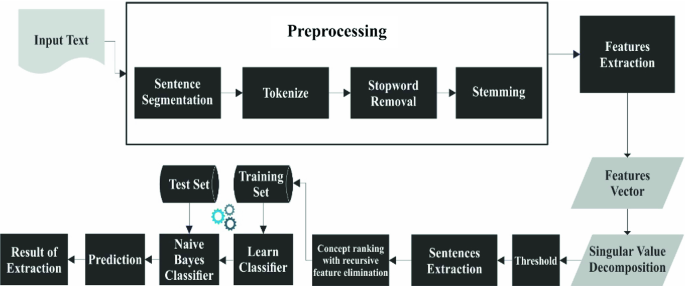

**Unzip the data into respective directory:**

In [13]:
!unzip -q /content/Dataset.zip -d /content/data

We begin with the assumption that our input stream is pre-processed, which allows us to apply the Naive Bayes algorithm effectively. We then elaborate the process further by performing feature extraction.

In [14]:
#Naive baye's classifier:
import pandas as pd #Dataframe Manipulation library
import numpy as np #Data Manipulation library

#sklearn modules for Feature Extraction & Modelling
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
#Libraries for Plotting
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from pylab import boxplot, text
import seaborn as sns
import joblib
import os
import glob

In [15]:
print(f"Current working directory is: {os.getcwd()}")
dir = os.chdir("/content")
print(f'Changing directory to {os.getcwd()}')

Current working directory is: /content/drive/MyDrive
Changing directory to /content


In [16]:
def load_data(folder_names, root_path):
    fileNames = [path + "/data/BBC News Summary/News Articles/" + folder + '/' + "*.txt"
        for path,folder in zip([root_path]*len(folder_names), folder_names)]
    #print(fileNames)
    #print("\n")
    doc_list = []
    tags = folder_names
    for docs in fileNames:
        #print(docs)
        doc = glob.glob(docs)#glob method iterates through all files and reads the text in documents in the folders
        for text in doc:
            with open(text, encoding="latin-1") as f:
                topic = docs.split('/')[len(docs.split('/'))-2]
                lines = f.readlines()
                heading = lines[0].strip()#stripping the text by spaces and using first element into heading
                body = ' '.join([l.strip() for l in lines[1:]])
                doc_list.append([topic,heading,body])
        print(f"Loading data from \033[1m{topic}\033[0m directory")
    print("\nEntire Data is loaded successfully")

    return doc_list

In [17]:
folder_names = ['business','entertainment','politics','sport','tech']
docs = load_data(folder_names=folder_names,root_path=os.getcwd())

Loading data from business directory
Loading data from entertainment directory
Loading data from politics directory
Loading data from sport directory
Loading data from tech directory

Entire Data is loaded successfully


In [18]:
docs = pd.DataFrame(docs, columns = ['Category','Heading','Article'])

In [19]:
docs.head()

,Category,Heading,Article
0,business,Takeover offer for Sunderland FC,"Bob Murray, chairman of Sunderland FC, has la..."
1,business,France Telecom gets Orange boost,Strong growth in subscriptions to mobile phon...
2,business,Jarvis sells Tube stake to Spain,Shares in engineering group Jarvis have soare...
3,business,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...
4,business,FAO warns on impact of subsidies,Billions of farmers' livelihoods are at risk ...


In [20]:
docs['text_len']=docs.Heading.apply(len)
docs['headlines_len']=docs.Article.apply(len)

<Axes: xlabel='Category'>

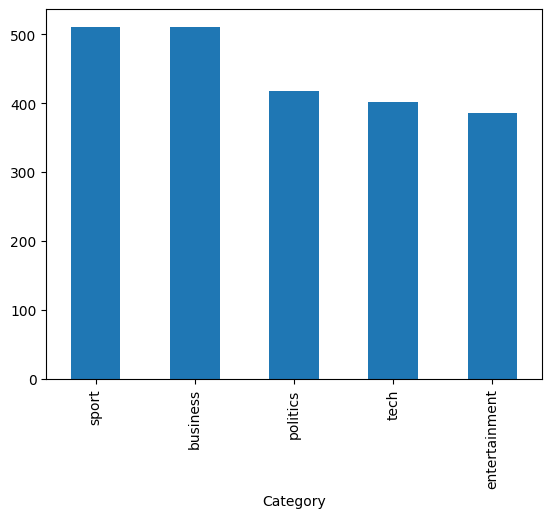

In [21]:
docs['Category'].value_counts().plot.bar()

In [22]:
docs.head()

,Category,Heading,Article,text_len,headlines_len
0,business,Takeover offer for Sunderland FC,"Bob Murray, chairman of Sunderland FC, has la...",32,1944
1,business,France Telecom gets Orange boost,Strong growth in subscriptions to mobile phon...,32,1756
2,business,Jarvis sells Tube stake to Spain,Shares in engineering group Jarvis have soare...,32,1444
3,business,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...,33,1535
4,business,FAO warns on impact of subsidies,Billions of farmers' livelihoods are at risk ...,32,1840


<Axes: xlabel='headlines_len', ylabel='Count'>

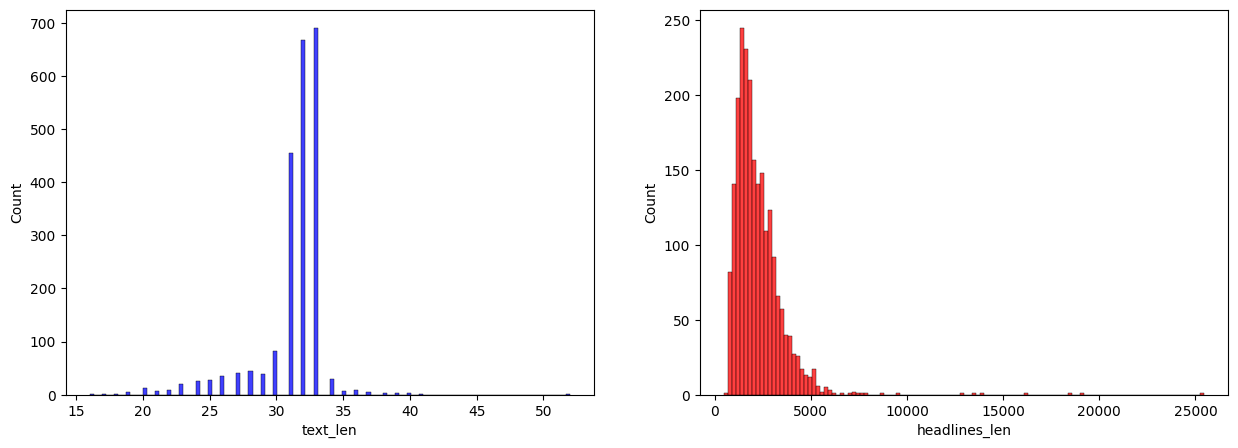

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
sns.histplot(docs.text_len, ax=axes[0], color='blue')
sns.histplot(docs.headlines_len, ax=axes[1], color='red')

In [24]:
tags_values = docs.Category.value_counts()
tags_values

,count
Category,
sport,511
business,510
politics,417
tech,401
entertainment,386


In [25]:
def plot_boxplot(df, varibale):
  fig1, ax1 = plt.subplots(figsize=(10,2))
  ax1.set_title(f'BoxPlot of {variable}', fontsize=18)
  values = list(df[variable].values)
  ax1.boxplot(values, vert=False, showfliers=False, widths = 0.6);

  bp_dict = boxplot(values, vert=False, showfliers=False, widths = 0.6)


  for line in bp_dict['medians']:
      # get position data for median line
      x, y = line.get_xydata()[1] # top of median line
      # overlay median value
      text(x, y+0.05, '%.1f' % x,
          horizontalalignment='center', fontsize=14) # draw above, centered

  for line in bp_dict['whiskers']:
      # get position data for median line
      x, y = line.get_xydata()[1] # top of median line
      # overlay median value
      text(x, y+0.3, '%.1f' % x,
          horizontalalignment='center', fontsize=14) # draw above, centered

  for line in bp_dict['boxes']:
      x, y = line.get_xydata()[0] # bottom of left line
      text(x,y-0.02, '%.1f' % x,
          horizontalalignment='center', # centered
          verticalalignment='top', fontsize=14)      # below
      x, y = line.get_xydata()[3] # bottom of right line
      text(x,y-0.02, '%.1f' % x,
          horizontalalignment='center', # centered
              verticalalignment='top', fontsize=14)      # below

  plt.xlabel(variable, fontsize=10)
  plt.xticks(fontsize=8)
  plt.yticks(fontsize=8)
  plt.show()

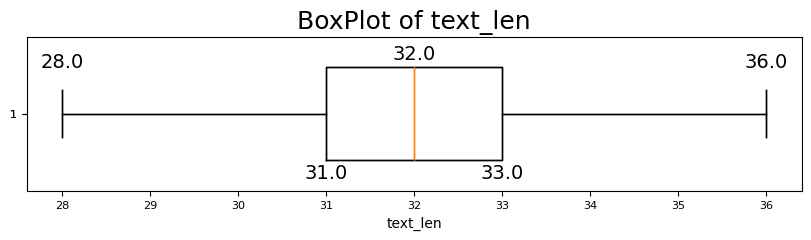

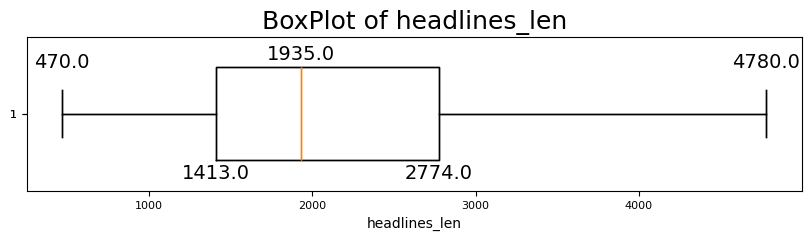

In [26]:
for variable in ['text_len','headlines_len']:
  plot_boxplot(docs, variable)

In [27]:
#Creating a list of text belonging to individual category of articles

heading_sport = docs[docs["Category"]=='sport']["Heading"] #Extracting the headings of the
#print(heading_sport)
collapsed_heading_sport =heading_sport.str.cat(sep = ' ') #
#print(collapsed_heading_sport)

heading_business = docs[docs["Category"]=='business']["Heading"] #Extracting the headings
collapsed_heading_business =heading_business.str.cat(sep = ' ')

heading_politics = docs[docs["Category"]=='politics']["Heading"]
collapsed_heading_politics =heading_politics.str.cat(sep = ' ')

heading_tech = docs[docs["Category"]=='tech']["Heading"]
collapsed_heading_tech =heading_tech.str.cat(sep = ' ')

heading_entertainment = docs[docs["Category"]=='entertainment']["Heading"]
collapsed_heading_entertainment =heading_entertainment.str.cat(sep = ' ')

In [28]:
#Creating List of Stopwords
stopwords = set(STOPWORDS)


Sports


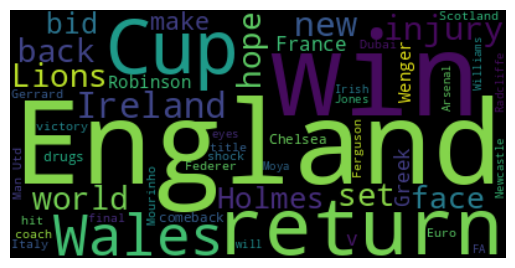


Business


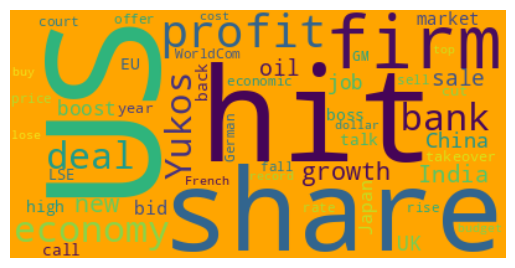

In [29]:
print('\033[1m'"\nSports"'\033[0m')
#Generate a Word Cloud for Sports
wordcloud = WordCloud(stopwords=stopwords, background_color='black', max_words=50).generate(collapsed_heading_sport)#Initializing the Word Cloud Class
#Display the generated Word cloud as image
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


print('\033[1m'"\nBusiness"'\033[0m')
#Generate a Word Cloud for Business
wordcloud = WordCloud(stopwords=stopwords, background_color='orange', max_words=50).generate(collapsed_heading_business)#Initializing the Word Cloud Class
#Display the generated Word cloud as image
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [30]:
"""
 Finally, the transformed data is fed into a
 Multinomial Naive Bayes classifier to predict the
 category or label of the input text.
"""
#Building pipeline for raw text transformation
clf = Pipeline([
    ('vect', CountVectorizer(stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('classifier', MultinomialNB()), #Apply the transformed data to Multinomial Naive Bayes Algo
])

In [31]:
x_train, x_test, y_train, y_test = train_test_split(docs['Heading'],docs['Category'],
                                                   random_state=42, test_size=0.2)
print(f"Size of input training data is {x_train.shape}")
print(f"Size of input test data is {x_test.shape}")
print(f"Size of output training data is {y_train.shape}")
print(f"Size of output test data is {y_test.shape}")

Size of input training data is (1780,)
Size of input test data is (445,)
Size of output training data is (1780,)
Size of output test data is (445,)


In [32]:
model = clf.fit(x_train,y_train) #fit the clf pipeline to training data

In [33]:
#Accuracy of the Naive Bayes Model
mdl_score = "{:.2f}".format(model.score(x_test,y_test) * 100)
print(f"The Accuracy of the Naive Bayes Classifier Model is {mdl_score}%")
print(f"\n{mdl_score}% of the times the model predicts the correct category for the news article")

The Accuracy of the Naive Bayes Classifier Model is 81.57%

81.57% of the times the model predicts the correct category for the news article


In [34]:
#Predicting on the test data
y_pred_NB = model.predict(x_test)
y_pred_NB[:5]


array(['business', 'business', 'sport', 'business', 'politics'],
      dtype='<U13')

In [35]:
#Confusion Matrix to evaluate the accuracy of a classification
cnf_mat = confusion_matrix(y_test,y_pred_NB)
np.set_printoptions(precision=2)
cnf_mat


array([[93,  1,  8,  9,  4],
       [ 7, 47,  4,  9,  5],
       [ 3,  0, 64,  8,  1],
       [ 8,  2,  1, 90,  1],
       [ 5,  2,  2,  2, 69]])

In [36]:
import itertools

def plot_confusion_matrix(cm,classes,
                          normalize = False,
                          title = "Confusion Matrix",
                          cmap = plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
        print("Normalized Confusion Matrix")
    else:
        print("Confusion Matrix, without Normalization")

    print(cm)
#show data as image using plt.imshow
    plt.imshow(cm,interpolation='nearest',cmap = cmap)
    plt.title(title)
    plt.colorbar()
#ARANGE : returns evenly spaced values from the given interval
# and the advantage of numpy.arange() over the normal in-built range() function is that it allows us to generate sequences of numbers that are not integers
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation = 45)
    plt.yticks(tick_marks,classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max()/2.
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,format(cm[i,j],fmt),
                 horizontalalignment = 'center',
                 color = 'white' if cm[i,j] > thresh else 'black')

    plt.xlabel = 'True Article Category'
    plt.ylabel = 'Predicted Article Category'



Confusion Matrix, without Normalization
[[93  1  8  9  4]
 [ 7 47  4  9  5]
 [ 3  0 64  8  1]
 [ 8  2  1 90  1]
 [ 5  2  2  2 69]]
Normalized Confusion Matrix
[[0.81 0.01 0.07 0.08 0.03]
 [0.1  0.65 0.06 0.12 0.07]
 [0.04 0.   0.84 0.11 0.01]
 [0.08 0.02 0.01 0.88 0.01]
 [0.06 0.03 0.03 0.03 0.86]]


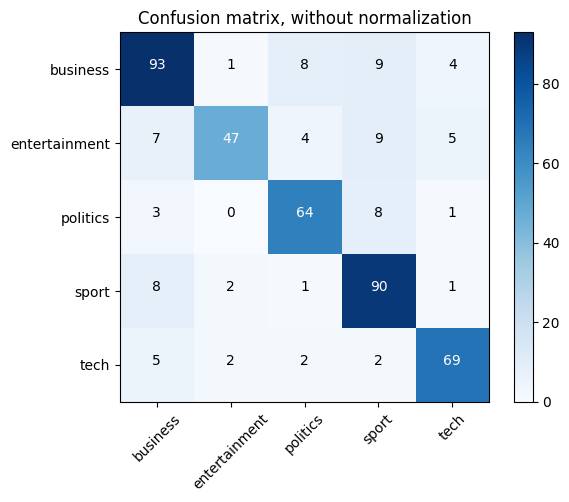

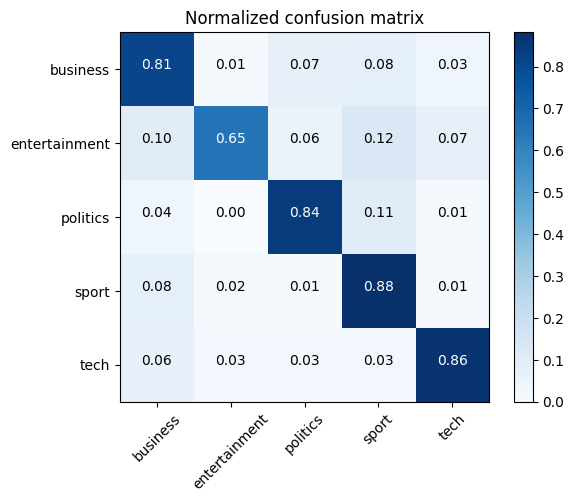

In [37]:
#Without Normalization
plt.figure()
plot_confusion_matrix(cnf_mat, classes=['business','entertainment','politics','sport','tech'],
                      title='Confusion matrix, without normalization')
# With normalization
plt.figure()
plot_confusion_matrix(cnf_mat,['business','entertainment','politics','sport','tech'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

95 true positives were predicted for class 0, 2 false positives were predicted for class 0, 10 false negatives were predicted for class 0, and 4 false negatives were predicted for class 0.
59 true positives were predicted for class 1, 2 false positives were predicted for class 1, 1 false negative was predicted for class 1, and 7 false negatives were predicted for class 1.
63 true positives were predicted for class 2, 8 false positives were predicted for class 2, 3 false negatives were predicted for class 2, and 2 false negatives were predicted for class 2.
87 true positives were predicted for class 3, 9 false positives were predicted for class 3, 3 false negatives were predicted for class 3, and 2 false negatives were predicted for class 3.
69 true positives were predicted for class 4, 5 false positives were predicted for class 4, 0 false negatives were predicted for class 4, and 4 false negatives were predicted for class 4.

**Decision Tree Classifier**

In [38]:
from sklearn.tree import DecisionTreeClassifier
clf_DT = Pipeline([
    ('vect', CountVectorizer(stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('classifier', DecisionTreeClassifier()), #Apply the transformed data to Multinomial Naive Bayes Algo
])

In [39]:
x_train, x_test, y_train, y_test = train_test_split(docs['Heading'],docs['Category'],
                                                   random_state=42, test_size=0.2)
print(f"Size of input training data is {x_train.shape}")
print(f"Size of input test data is {x_test.shape}")
print(f"Size of output training data is {y_train.shape}")
print(f"Size of output test data is {y_test.shape}")

Size of input training data is (1780,)
Size of input test data is (445,)
Size of output training data is (1780,)
Size of output test data is (445,)


In [40]:
model_Decision_Tree = clf_DT.fit(x_train,y_train)
model_score_Decision_Tree = "{:.2f}".format(model_Decision_Tree.score(x_test,y_test) * 100)
print(f"The Accuracy of the Decision Tree Classifier Model is {model_score_Decision_Tree}%")
print(f"\n{model_score_Decision_Tree}% of the times the model predicts the correct category for the news articles")

The Accuracy of the Decision Tree Classifier Model is 67.87%

67.87% of the times the model predicts the correct category for the news articles


In [41]:
y_pred_DT = model.predict(x_test)
y_pred_DT[:10]

array(['business', 'business', 'sport', 'business', 'politics', 'sport',
       'sport', 'politics', 'sport', 'politics'], dtype='<U13')

### **Comparison Analysis:**
Decision Trees tend to have lower accuracy compared to Naive Bayes Model when dealing with high dimensional feature space. Based on the experimental results, the Naive Bayes Classifier Model achieved the highest accuracy with **83.82%**. In contrast, the Decision Tree Classifier Model achieved lower accuracy of **70.34%**, respectively.

**TextRank Algorithm**

In [42]:
# Provide the path to your PNG file
image_path = '/content/electronics-12-00372-g001.png'

# Display the image
#Image(filename=image_path, width=500, height=500)

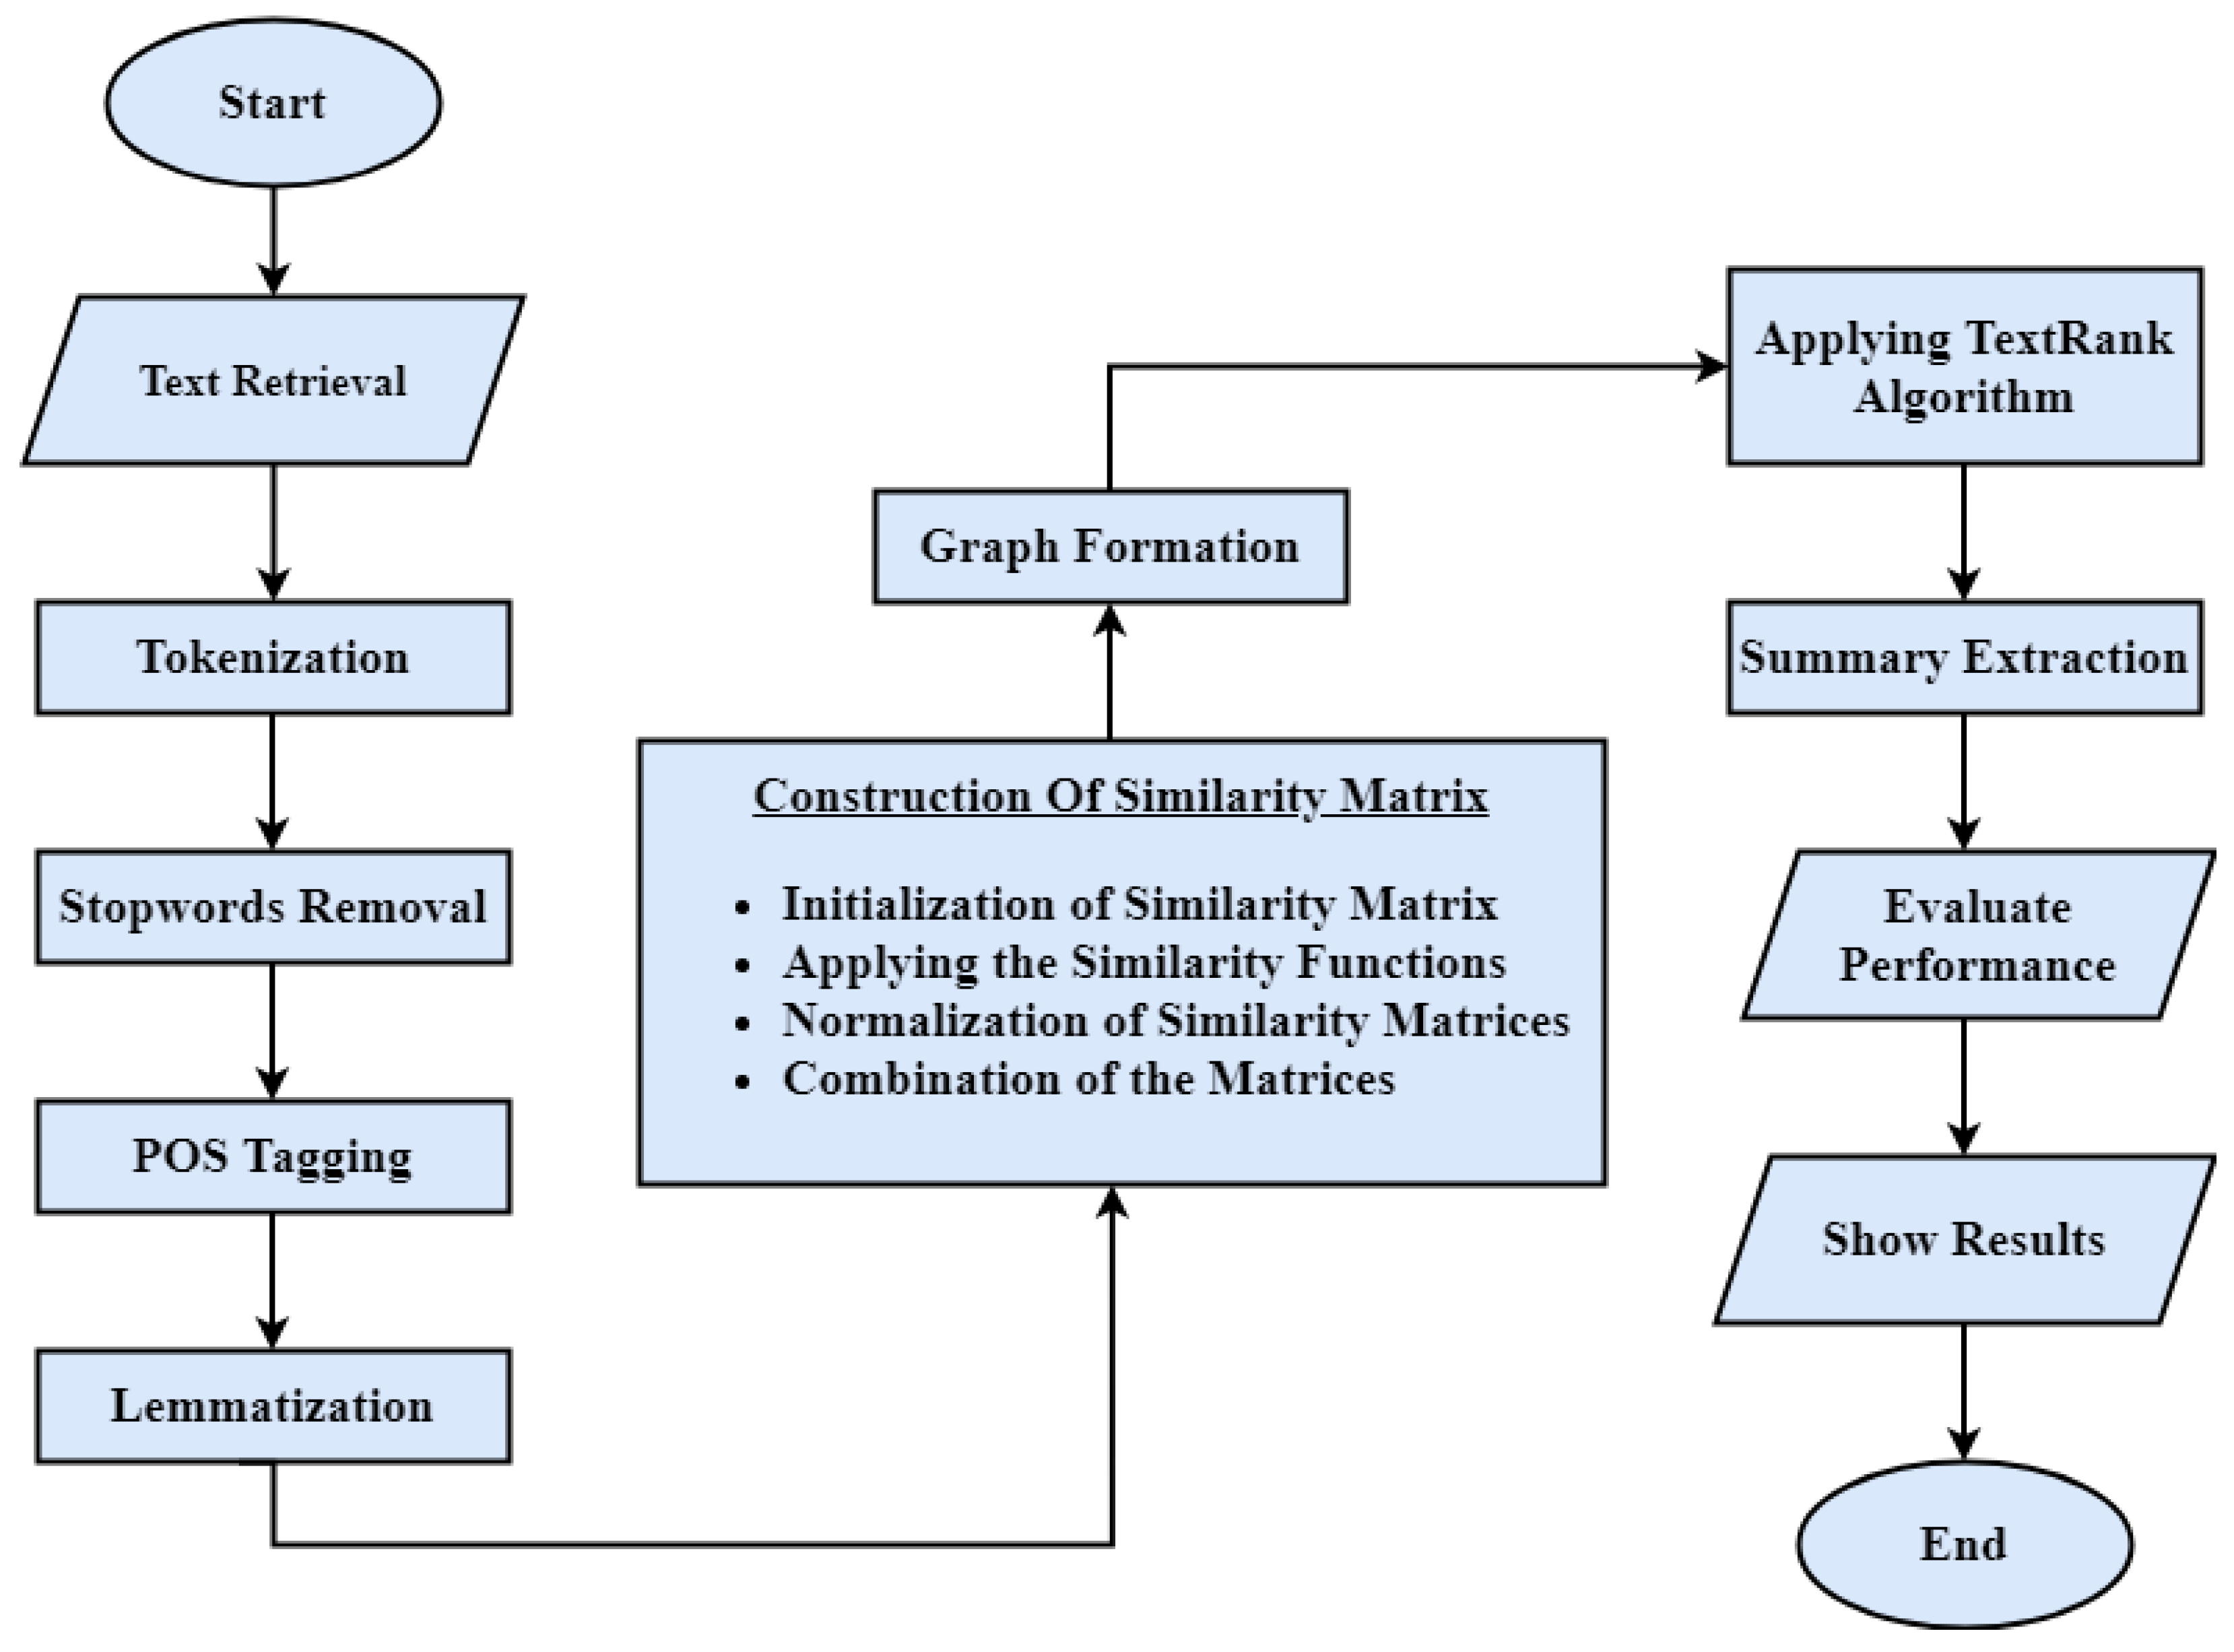

In [43]:
class SummarizationModel:
  def __init__(self, compression_ratio = 0.4, d = 0.15, model = model_skipgram):
    self.compression_ratio = compression_ratio
    self.d = d
    self.model = model

  def preprocess(self, news):

    #tokenize sentences
    indexes = []
    sentences = sent_tokenize(news)
    og_sentences = []
    for sent in sentences:
      splitting = sent.split('\n')
      for split in splitting:
        split = split.strip()
        og_sentences.append(split)

    while '' in og_sentences:
      og_sentences.remove('')


    #remove stop words
    word_tokenization = [word_tokenize(x) for x in og_sentences]
    stop_words_removal = [list(filter(lambda x: x not in stopwords.words('english'), sent)) for sent in word_tokenization]

    #stemming
    porter = PorterStemmer()
    stemmed_words = [list(map(porter.stem, sent)) for sent in stop_words_removal]
    stemmed_sentences = [" ".join(sentence) for sentence in stemmed_words]

    #further data cleaning
    for i in range(len(stemmed_sentences)):
      stemmed_sentences[i] = stemmed_sentences[i].replace(',', '')
      stemmed_sentences[i] = stemmed_sentences[i].replace('.', '')
      stemmed_sentences[i] = stemmed_sentences[i].replace('`', '')
      stemmed_sentences[i] = stemmed_sentences[i].replace('\'', '')
      stemmed_sentences[i] = stemmed_sentences[i].replace('\'s', '')
      stemmed_sentences[i] = stemmed_sentences[i].replace(':', '')
      stemmed_sentences[i] = stemmed_sentences[i].replace('.', '')
      stemmed_sentences[i] = stemmed_sentences[i].replace(';', '')
      stemmed_sentences[i] = stemmed_sentences[i].replace('(', '')
      stemmed_sentences[i] = stemmed_sentences[i].replace(')', '')
      stemmed_sentences[i] = stemmed_sentences[i].replace('-', '')
      stemmed_sentences[i] = stemmed_sentences[i].strip()

    while '' in stemmed_sentences:
      stemmed_sentences.remove('')

    #storing vectors
    sentence_vectors = []
    for i in range(len(stemmed_sentences)):
      vector = self.model.get_word_vector(stemmed_sentences[i])
      sentence_vectors.append((tuple(vector), og_sentences[i]))

    return sentence_vectors

  def cosine_similarity(self, v1, v2):
    return 1 - spatial.distance.cosine(v1,v2)

  def update_scores(self, scores, adj_list, T):
    for node in scores.keys():
      tr = 0
      for adj_node in adj_list[node]:
        tr+=scores[adj_node[0]]/len(adj_list[adj_node[0]])
      TR = self.d/T + (1-self.d)*tr
      scores[node] = TR

  def generateSummary(self, news):
    sentence_vectors = self.preprocess(news)
    adj_list = {}
    sum = 0
    count = 0

    #creating graph
    for i in range(len(sentence_vectors)):
      for j in range(i+1, len(sentence_vectors)):
        if sentence_vectors[i][0] not in adj_list.keys():
          adj_list[sentence_vectors[i][0]] = []
        if sentence_vectors[j][0] not in adj_list.keys():
          adj_list[sentence_vectors[j][0]] = []
        similarity = self.cosine_similarity(sentence_vectors[i][0], sentence_vectors[j][0])
        sum += similarity
        count +=1

        adj_list[sentence_vectors[i][0]].append((sentence_vectors[j][0], similarity))
        adj_list[sentence_vectors[j][0]].append((sentence_vectors[i][0], similarity))

    average = sum/count

    #dropping edges below average
    for key in adj_list.keys():
      for value in adj_list[key]:
        if value[1]<average:
          adj_list[key].remove(value)

    #initialising scores
    scores = {node: mean([x[1] for x in adj_list[node]]) for node in list(adj_list.keys())}
    #updating scores
    for i in range (50) : self.update_scores(scores, adj_list, len(adj_list))
    #sorting nodes by score
    sorted_score = dict(sorted(scores.items(), key=lambda item: item[1], reverse = True))

    #obtaining original sentences
    sentences = []
    for key in sorted_score.keys():
      for i in range(len(sentence_vectors)):
        if key == sentence_vectors[i][0]:
          sentences.append((sentence_vectors[i][1], i))

    #generating the final summary
    top_sentences = sentences[0:ceil(self.compression_ratio*len(sentence_vectors))]
    top_sentences = sorted(top_sentences, key = lambda x : x[1])
    summary = " ". join([x[0] for x in top_sentences])

    return summary

In [47]:
import fasttext
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer
nltk.download('punkt')
nltk.download('stopwords')
from scipy import spatial
from statistics import mean
from math import ceil
from rouge_score import rouge_scorer
import os
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [50]:
#individual testing
#domain = 'sport'
#number = '052'
news_path = f'/content/data/BBC News Summary/News Articles/sport/052.txt'
ans_path = f'/content/data/BBC News Summary/Summaries/sport/052.txt'
f1 = open(news_path, 'r')
f2 = open(ans_path, 'r')
news = f1.read()
answer = f2.read()

model = SummarizationModel()
model.model = model_skipgram
model.compression_ratio = 0.4
model.d = 0.15
summary = model.generateSummary(news)
scorer = rouge_scorer.RougeScorer(['rouge1','rouge2', 'rougeL'], use_stemmer=True)
scores = scorer.score(summary,answer)

scores

{'rouge1': Score(precision=0.45588235294117646, recall=0.4189189189189189, fmeasure=0.4366197183098592),
 'rouge2': Score(precision=0.3283582089552239, recall=0.3013698630136986, fmeasure=0.3142857142857143),
 'rougeL': Score(precision=0.4117647058823529, recall=0.3783783783783784, fmeasure=0.39436619718309857)}

In [51]:
answer

"Holmes will make her first track appearance on home soil since winning double Olympic gold in January's Norwich Union International in Glasgow.The Glasgow meeting will see Holmes compete over 1500m in a five-way match against Sweden, France, Russia and Italy.She will also run in the Grand Prix in Birmingham in February and may defend her indoor AAA 800m title in Sheffield earlier that month."

In [53]:
summary

'Holmes starts 2005 with GB events Holmes will make her first track appearance on home soil since winning double Olympic gold in January\'s Norwich Union International in Glasgow. "I am still competitive and still want to win," she said. She added: "These events are also a great opportunity to thank the British public for the enormous levels of support they have given me from the moment I stepped off that plane from Greece."'

In [54]:
scores

{'rouge1': Score(precision=0.45588235294117646, recall=0.4189189189189189, fmeasure=0.4366197183098592),
 'rouge2': Score(precision=0.3283582089552239, recall=0.3013698630136986, fmeasure=0.3142857142857143),
 'rougeL': Score(precision=0.4117647058823529, recall=0.3783783783783784, fmeasure=0.39436619718309857)}

In [55]:
#dataset testing
domains =  ['business', 'entertainment', 'politics', 'sport', 'tech']
base_news_path = '/content/data/BBC News Summary/News Articles/'
base_summaries_path = '/content/data/BBC News Summary/Summaries/'
news_list = []
summaries_list = []
name_list = []
exceptions = []
for domain in domains:
  news_path = base_news_path + domain + '/'
  summary_path = base_summaries_path + domain + '/'
  for name in os.listdir(news_path):
    news_full_path = news_path + name
    summary_full_path = summary_path + name
    f1 = open(news_full_path, "r")
    f2 = open(summary_full_path, "r")
    try:
      news_list.append(f1.read())
      summaries_list.append(f2.read())
      name_list.append(name)
    except:
      exceptions.append(name)
      print(name)
    finally:
      f1.close()
      f2.close()

199.txt


In [56]:
len(name_list)

2224

In [57]:
scorer = rouge_scorer.RougeScorer(['rouge1','rouge2', 'rougeL'], use_stemmer=True)
rouge_1 = [0,0,0]
rouge_2 = [0,0,0]
rouge_L = [0,0,0]
count = 0
for i in range(len(news_list)):
  my_summary = model.generateSummary(news_list[i])
  scores = scorer.score(my_summary,summaries_list[i])
  rouge_1[0] += scores['rouge1'].precision
  rouge_1[1] += scores['rouge1'].recall
  rouge_1[2] += scores['rouge1'].fmeasure
  rouge_2[0] += scores['rouge2'].precision
  rouge_2[1] += scores['rouge2'].recall
  rouge_2[2] += scores['rouge2'].fmeasure
  rouge_L[0] += scores['rougeL'].precision
  rouge_L[1] += scores['rougeL'].recall
  rouge_L[2] += scores['rougeL'].fmeasure
  if scores['rouge1'].precision<0.5:
    print(name_list[i])
  count+=1

rouge_1 = [x/count for x in rouge_1]
rouge_2 = [x/count for x in rouge_2]
rouge_L = [x/count for x in rouge_L]

161.txt
388.txt
174.txt
343.txt
315.txt
371.txt
255.txt
116.txt
372.txt
220.txt
490.txt
011.txt
274.txt
218.txt
256.txt
300.txt
410.txt
497.txt
367.txt
041.txt
226.txt
310.txt
308.txt
185.txt
074.txt
124.txt
219.txt
223.txt
087.txt
343.txt
101.txt
371.txt
330.txt
001.txt
116.txt
230.txt
266.txt
170.txt
249.txt
068.txt
083.txt
088.txt
300.txt
098.txt
160.txt
189.txt
237.txt
310.txt
194.txt
123.txt
391.txt
225.txt
220.txt
413.txt
093.txt
067.txt
506.txt
463.txt
310.txt
123.txt
439.txt
074.txt
437.txt
193.txt
458.txt
304.txt
007.txt
390.txt
077.txt
071.txt
019.txt
459.txt
356.txt
276.txt
485.txt
255.txt
504.txt
350.txt
153.txt
511.txt
249.txt
201.txt
392.txt
295.txt
259.txt
084.txt
033.txt
457.txt
351.txt
081.txt
256.txt
277.txt
252.txt
444.txt
078.txt
052.txt
334.txt
379.txt
241.txt
238.txt
160.txt


In [58]:
rouge_1

[0.7104291770962189, 0.6558882581483492, 0.678365778150034]

In [59]:
rouge_2

[0.5812766854381396, 0.5366475405452141, 0.5550693103238133]

In [60]:
rouge_L

[0.4450955125143373, 0.4114331942604242, 0.42511656005879794]

In [61]:
#Confusion Matrix to evaluate the accuracy of a classification
cnf_mat = confusion_matrix(y_test,y_pred_NB)
np.set_printoptions(precision=2)
cnf_mat

array([[93,  1,  8,  9,  4],
       [ 7, 47,  4,  9,  5],
       [ 3,  0, 64,  8,  1],
       [ 8,  2,  1, 90,  1],
       [ 5,  2,  2,  2, 69]])

In [62]:
model = clf.fit(x_train,y_train) #fit the clf pipeline to training data

In [63]:
#Accuracy of the Naive Bayes Model
mdl_score = "{:.2f}".format(model.score(x_test,y_test) * 100)
print(f"The Accuracy of the Naive Bayes Classifier Model is {mdl_score}%")
print(f"\n{mdl_score}% of the times the model predicts the correct category for the news article")

The Accuracy of the Naive Bayes Classifier Model is 81.57%

81.57% of the times the model predicts the correct category for the news article


In [64]:
#Predicting on the test data
y_pred_NB = model.predict(x_test)
y_pred_NB[:5]

array(['business', 'business', 'sport', 'business', 'politics'],
      dtype='<U13')

In [65]:
#Confusion Matrix to evaluate the accuracy of a classification
cnf_mat = confusion_matrix(y_test,y_pred_NB)
np.set_printoptions(precision=2)
cnf_mat

array([[93,  1,  8,  9,  4],
       [ 7, 47,  4,  9,  5],
       [ 3,  0, 64,  8,  1],
       [ 8,  2,  1, 90,  1],
       [ 5,  2,  2,  2, 69]])

In [66]:
import itertools

def plot_confusion_matrix(cm,classes,
                          normalize = False,
                          title = "Confusion Matrix",
                          cmap = plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
        print("Normalized Confusion Matrix")
    else:
        print("Confusion Matrix, without Normalization")

    print(cm)
#show data as image using plt.imshow
    plt.imshow(cm,interpolation='nearest',cmap = cmap)
    plt.title(title)
    plt.colorbar()
#ARANGE : returns evenly spaced values from the given interval
# and the advantage of numpy.arange() over the normal in-built range() function is that it allows us to generate sequences of numbers that are not integers
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation = 45)
    plt.yticks(tick_marks,classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max()/2.
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,format(cm[i,j],fmt),
                 horizontalalignment = 'center',
                 color = 'white' if cm[i,j] > thresh else 'black')

    plt.xlabel = 'True Article Category'
    plt.ylabel = 'Predicted Article Category'

Confusion Matrix, without Normalization
[[93  1  8  9  4]
 [ 7 47  4  9  5]
 [ 3  0 64  8  1]
 [ 8  2  1 90  1]
 [ 5  2  2  2 69]]
Normalized Confusion Matrix
[[0.81 0.01 0.07 0.08 0.03]
 [0.1  0.65 0.06 0.12 0.07]
 [0.04 0.   0.84 0.11 0.01]
 [0.08 0.02 0.01 0.88 0.01]
 [0.06 0.03 0.03 0.03 0.86]]


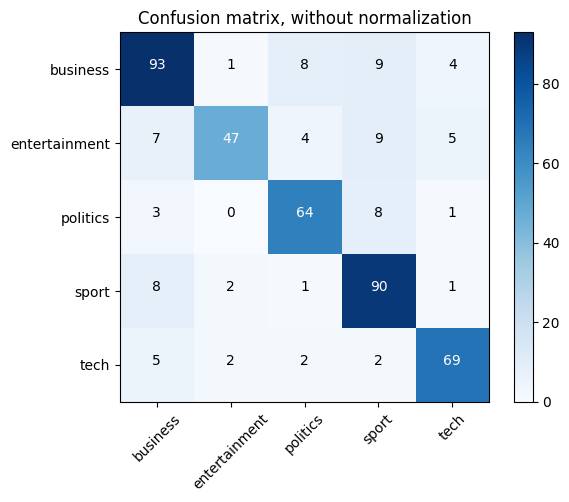

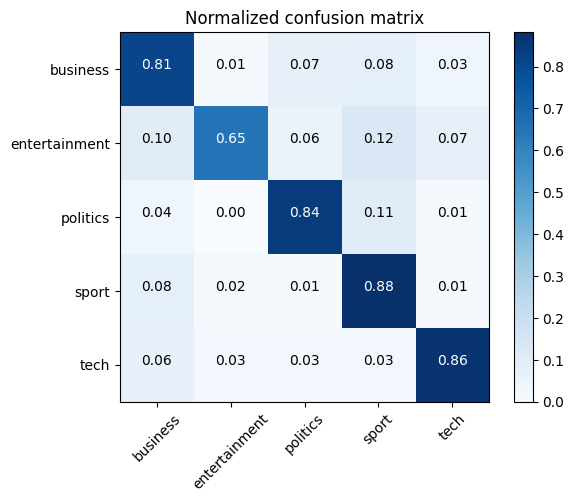

In [67]:
#Without Normalization
plt.figure()
plot_confusion_matrix(cnf_mat, classes=['business','entertainment','politics','sport','tech'],
                      title='Confusion matrix, without normalization')
# With normalization
plt.figure()
plot_confusion_matrix(cnf_mat,['business','entertainment','politics','sport','tech'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()